In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.optimizers import Adam
from src.record import load_records
from src.losses import reduce_std
from src.model import create_model

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

2023-06-27 23:28:53.707809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 23:28:53.850631: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://

In [3]:
test_ds = load_records('./data/records/f_dhtau/fold_0/test')

2023-06-27 23:28:55.270151: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (34)
2023-06-27 23:28:55.270185: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (5ede3d022be0): /proc/driver/nvidia/version does not exist
2023-06-27 23:28:55.270433: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
window_size = 50
model = create_model(window_size=window_size)
model.load_weights('./logs/test/weigths')

In [5]:
optimizer = Adam(1e-3)
model.compile(loss_fn=reduce_std)

In [12]:
# model.summary()

In [7]:
model.evaluate(test_ds)

1/1 [==============================] - 1s 885ms/step - loss: 2.1384


2.138396739959717

In [8]:
flux_pred = model.predict(test_ds)

1/1 [==============================] - 1s 591ms/step


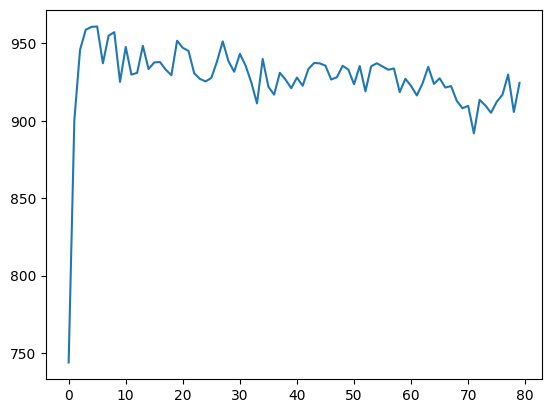

In [11]:
plt.plot(flux_pred[0])